task 50

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset with correct format
df = pd.read_csv('newsCorpora.csv', sep='\t', header=None,
                names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# Filter by publisher
valid_publishers = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
df = df[df['PUBLISHER'].isin(valid_publishers)]

# Filter to only the 4 specified categories
valid_categories = ['b', 'e', 'm', 't']  # b:business, e:entertainment, m:health, t:science/tech
df = df[df['CATEGORY'].isin(valid_categories)]

# Map category codes to full names
category_map = {'b': 'Business', 'e': 'Entertainment', 'm': 'Health', 't': 'Science'}
df['CATEGORY'] = df['CATEGORY'].map(category_map)

# Randomly shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into train (80%), valid (10%), test (10%)
train, temp = train_test_split(df, test_size=0.2, random_state=42)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)

# Save to files
def save_data(data, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for _, row in data.iterrows():
            f.write(f"{row['CATEGORY']}\t{row['TITLE']}\n")

save_data(train, 'train.txt')
save_data(valid, 'valid.txt')
save_data(test, 'test.txt')

# Check category distribution
print("Training data distribution:")
print(train['CATEGORY'].value_counts())
print("\nValidation data distribution:")
print(valid['CATEGORY'].value_counts())
print("\nTest data distribution:")
print(test['CATEGORY'].value_counts())

Training data distribution:
CATEGORY
Business         4511
Entertainment    4225
Science          1204
Health            732
Name: count, dtype: int64

Validation data distribution:
CATEGORY
Business         548
Entertainment    539
Science          162
Health            85
Name: count, dtype: int64

Test data distribution:
CATEGORY
Business         568
Entertainment    515
Science          158
Health            93
Name: count, dtype: int64


task 51

In [2]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

# Load spaCy model for tokenization
nlp = spacy.load('en_core_web_sm')

# Custom tokenizer using spaCy
def spacy_tokenizer(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, lowercase=True, stop_words='english')

# Fit on training data and transform all datasets
train_features = vectorizer.fit_transform(train['TITLE'])
valid_features = vectorizer.transform(valid['TITLE'])
test_features = vectorizer.transform(test['TITLE'])

# Save features
def save_features(features, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for i in range(features.shape[0]):
            # Get non-zero features for this instance
            feature_string = " ".join([f"{idx}:{val}" for idx, val in zip(features[i].indices, features[i].data)])
            f.write(f"{feature_string}\n")

save_features(train_features, 'train.feature.txt')
save_features(valid_features, 'valid.feature.txt')
save_features(test_features, 'test.feature.txt')

/home/jace/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/jace/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make', 'whereaft'] not in stop_words.
  warnings.warn(


task 52

In [4]:
from sklearn.linear_model import LogisticRegression

# Initialize and train logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(train_features, train['CATEGORY'])

# Save the model
import joblib
joblib.dump(model, 'news_classifier.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

task 53

In [5]:
def predict_news_category(headline):
    # Load model and vectorizer
    model = joblib.load('news_classifier.joblib')
    vectorizer = joblib.load('tfidf_vectorizer.joblib')
    
    # Transform the input
    features = vectorizer.transform([headline])
    
    # Make prediction
    pred = model.predict(features)[0]
    proba = model.predict_proba(features)[0]
    
    # Format probabilities
    categories = model.classes_
    proba_dict = {cat: f"{prob:.2%}" for cat, prob in zip(categories, proba)}
    
    return pred, proba_dict

# Example usage
headline = "Apple announces new quantum computing research initiative"
category, probabilities = predict_news_category(headline)
print(f"Predicted category: {category}")
print("Probabilities:")
for cat, prob in probabilities.items():
    print(f"{cat}: {prob}")

Predicted category: Science
Probabilities:
Business: 6.48%
Entertainment: 11.07%
Health: 5.21%
Science: 77.23%


/home/jace/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'make', 'whereaft'] not in stop_words.
  warnings.warn(


task 54

In [6]:
from sklearn.metrics import accuracy_score

# Predictions
train_pred = model.predict(train_features)
test_pred = model.predict(test_features)

# Calculate accuracy
train_accuracy = accuracy_score(train['CATEGORY'], train_pred)
test_accuracy = accuracy_score(test['CATEGORY'], test_pred)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

Training Accuracy: 94.87%
Test Accuracy: 89.36%


task 55

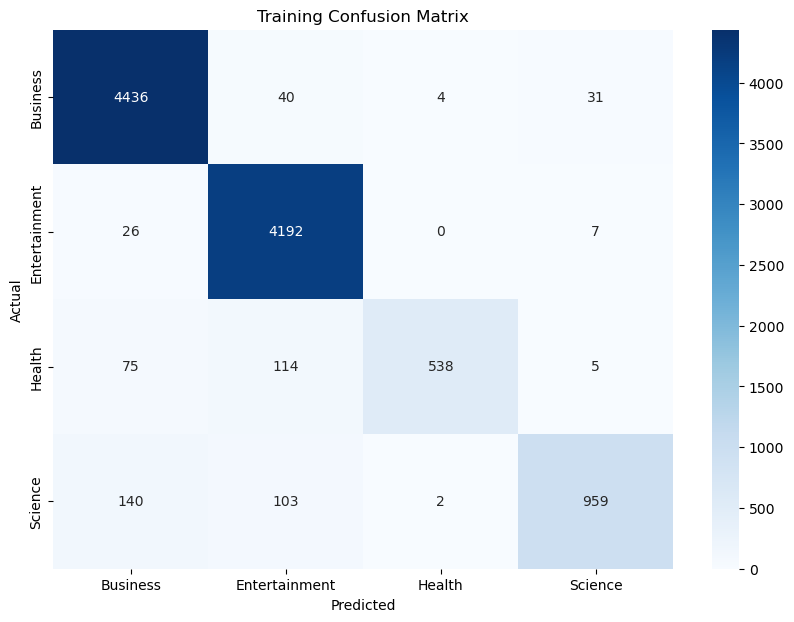

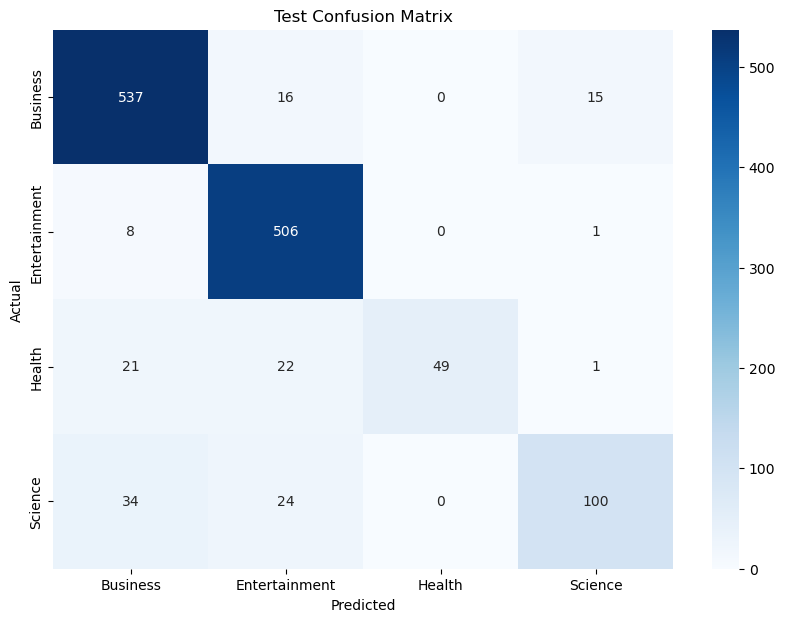

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrices
train_cm = confusion_matrix(train['CATEGORY'], train_pred, labels=model.classes_)
test_cm = confusion_matrix(test['CATEGORY'], test_pred, labels=model.classes_)

# Plot training confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot test confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

task 56

In [8]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Calculate metrics
train_metrics = precision_recall_fscore_support(train['CATEGORY'], train_pred, labels=model.classes_)
test_metrics = precision_recall_fscore_support(test['CATEGORY'], test_pred, labels=model.classes_)

# Micro and macro averages
print("Training Classification Report:")
print(classification_report(train['CATEGORY'], train_pred, target_names=model.classes_))

print("\nTest Classification Report:")
print(classification_report(test['CATEGORY'], test_pred, target_names=model.classes_))

Training Classification Report:
               precision    recall  f1-score   support

     Business       0.95      0.98      0.97      4511
Entertainment       0.94      0.99      0.97      4225
       Health       0.99      0.73      0.84       732
      Science       0.96      0.80      0.87      1204

     accuracy                           0.95     10672
    macro avg       0.96      0.88      0.91     10672
 weighted avg       0.95      0.95      0.95     10672


Test Classification Report:
               precision    recall  f1-score   support

     Business       0.90      0.95      0.92       568
Entertainment       0.89      0.98      0.93       515
       Health       1.00      0.53      0.69        93
      Science       0.85      0.63      0.73       158

     accuracy                           0.89      1334
    macro avg       0.91      0.77      0.82      1334
 weighted avg       0.90      0.89      0.89      1334



task 57

In [9]:
# Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_

# Create a DataFrame to store feature importance
importance_df = pd.DataFrame()

for i, class_name in enumerate(model.classes_):
    # Get coefficients for this class
    class_coef = coefficients[i]
    
    # Create DataFrame for this class
    class_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': class_coef,
        'class': class_name
    })
    
    # Sort by absolute value of coefficient
    class_df['abs_coef'] = class_df['coefficient'].abs()
    class_df = class_df.sort_values('abs_coef', ascending=False)
    
    # Append to importance_df
    importance_df = pd.concat([importance_df, class_df])

# Display top and bottom features for each class
for class_name in model.classes_:
    class_data = importance_df[importance_df['class'] == class_name]
    
    print(f"\nTop 10 features for {class_name}:")
    print(class_data.head(10)[['feature', 'coefficient']])
    
    print(f"\nBottom 10 features for {class_name}:")
    print(class_data.tail(10)[['feature', 'coefficient']])


Top 10 features for Business:
      feature  coefficient
1295     bank     3.613717
9033    stock     3.529799
3787      fed     3.280825
2153    china     3.257091
3332      ecb     3.141287
3571     euro     2.816546
9780  ukraine     2.673568
6789      oil     2.631004
7505   profit     2.556084
3157   dollar     2.549925

Bottom 10 features for Business:
       feature  coefficient
8857   speaker     0.000754
8585    sickly    -0.000735
4884      idea    -0.000715
3955   florida    -0.000691
4964   include    -0.000681
10430     year    -0.000573
8263      sand    -0.000417
10027  vicious     0.000093
1568      blow     0.000083
8593     sight    -0.000017

Top 10 features for Entertainment:
         feature  coefficient
5347  kardashian     3.341685
8974        star     2.933436
69             1    -2.789202
4330      google    -2.737662
2175       chris     2.727903
9908      update    -2.654562
3849        film     2.630506
5414         kim     2.502935
6246       miley     2.5

task 58

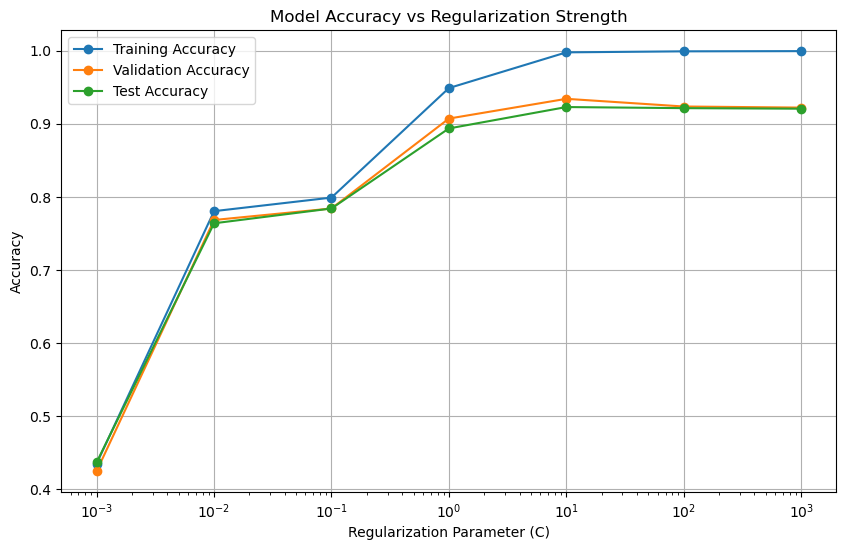

In [10]:
import matplotlib.pyplot as plt

# Different regularization parameters
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

train_accuracies = []
valid_accuracies = []
test_accuracies = []

for C in C_values:
    # Train model with current C value
    lr_model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    lr_model.fit(train_features, train['CATEGORY'])
    
    # Calculate accuracies
    train_acc = lr_model.score(train_features, train['CATEGORY'])
    valid_acc = lr_model.score(valid_features, valid['CATEGORY'])
    test_acc = lr_model.score(test_features, test['CATEGORY'])
    
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    test_accuracies.append(test_acc)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(C_values, valid_accuracies, label='Validation Accuracy', marker='o')
plt.plot(C_values, test_accuracies, label='Test Accuracy', marker='o')
plt.xscale('log')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Regularization Strength')
plt.legend()
plt.grid()
plt.show()

task 59

In [11]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize grid search
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit on training data
grid_search.fit(train_features, train['CATEGORY'])

# Best parameters and model
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate on validation set
valid_accuracy = best_model.score(valid_features, valid['CATEGORY'])
print(f"Validation Accuracy with Best Model: {valid_accuracy:.2%}")

# Evaluate on test set
test_accuracy = best_model.score(test_features, test['CATEGORY'])
print(f"Test Accuracy with Best Model: {test_accuracy:.2%}")

/home/jace/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jace/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jace/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jace/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jace/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/ho

Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Validation Accuracy with Best Model: 92.95%
Test Accuracy with Best Model: 92.58%
